In [12]:
import torch
from hist_optimizer import tensor_to_param_container, mse_engines_comparison, Model, find_good_offset_problem, optimize_smart_walker, optimize_brute, evaluate_evaluation_method, plot_param_tensors, tensor_list_to_param_container_list

from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate, StandardizeXYHist, HistSurrogateEngine
from ray_tools.base.engine import RayEngine
from ray_tools.base.backend import RayBackendDockerRAYUI
from ray_optim.plot import Plot
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

In [2]:
engine = RayEngine(rml_basefile='rml_src/METRIX_U41_G1_H1_318eV_PS_MLearn_1.15.rml',
                                exported_planes=["ImagePlane"],
                                ray_backend=RayBackendDockerRAYUI(docker_image='ray-ui-service',
                                                                  docker_container_name='ray-ui-service-test',
                                                                  dockerfile_path='ray_docker/rayui',
                                                                  ray_workdir='/dev/shm/ray-workdir',
                                                                  verbose=False),
                                num_workers=-1,
                                as_generator=False)
surrogate_engine = HistSurrogateEngine(checkpoint_path="outputs/xy_hist/qhmpdasi/checkpoints/epoch=295-step=118652488.ckpt")

model = Model()

Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=72, bias=True)
  (3): Mish()
  (4): Linear(in_features=72, out_features=77, bias=True)
  (5): Mish()
  (6): Linear(in_features=77, out_features=82, bias=True)
  (7): Mish()
  (8): Linear(in_features=82, out_features=87, bias=True)
  (9): Mish()
  (10): Linear(in_features=87, out_features=93, bias=True)
  (11): Mish()
  (12): Linear(in_features=93, out_features=100, bias=True)
  (13): Sigmoid()
)
Sequential(
  (0): Linear(in_features=34, out_features=68, bias=True)
  (1): Mish()
  (2): Linear(in_features=68, out_features=72, bias=True)
  (3): Mish()
  (4): Linear(in_features=72, out_features=77, bias=True)
  (5): Mish()
  (6): Linear(in_features=77, out_features=82, bias=True)
  (7): Mish()
  (8): Linear(in_features=82, out_features=87, bias=True)
  (9): Mish()
  (10): Linear(in_features=87, out_features=93, bias=True)
  (11): Mish()
  (12): Linear(in_features=9

In [21]:
Plot.plot_engines_comparison(engine, surrogate_engine, [tensor_to_param_container(torch.ones((34))*0.5)], MultiLayer([0.]))

NameError: name 'MultiLayer' is not defined

# Datamodule

In [ ]:
load_len: int | None = 10000
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/data_raw_*.h5'))
dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], transform=Select(keys=['1e5/params', '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': surrogate_engine.model.standardizer}))


bal_memory_dataset = BalancedMemoryDataset(dataset=dataset, load_len=load_len, min_n_rays=500)
memory_dataset = MemoryDataset(dataset=dataset, load_len=load_len)
datamodule = DefaultDataModule(dataset=bal_memory_dataset, num_workers=4)
datamodule.prepare_data()
datamodule.setup(stage="test")
test_dl = datamodule.test_dataloader()

unbal_datamodule = DefaultDataModule(dataset=memory_dataset, num_workers=4)
unbal_datamodule.prepare_data()
unbal_datamodule.setup(stage="test")
unbal_test_dl = unbal_datamodule.test_dataloader()

## Maximum distribution

In [ ]:
value_list = []
params_list = []

for i in tqdm.tqdm(unbal_test_dl):
    biggest = i[1].flatten(start_dim=1)
    biggest, _ = i[1].flatten(start_dim=1).max(dim=1)
    mask = biggest > 0.8
    value_list.append(biggest[mask])
    params_list.append(i[0][mask])
value_tensor = torch.cat(value_list)
params_tensor = torch.cat(params_list)

torch.save(value_tensor, 'outputs/values.pt')
torch.save(params_tensor, 'outputs/params.pt')
plt.hist(value_tensor)
plt.savefig('outputs/max_dist_hist.png')

In [ ]:
value_tensor = torch.load('outputs/values.pt')
params_tensor = torch.load('outputs/params.pt')

# Special sample

In [ ]:
with open("outputs/special_sample_168_selected.pkl", "rb") as f:
    special_sample = pickle.load(f, fix_imports=True, encoding='ASCII', errors='strict', buffers=None)
observed_params = special_sample.uncompensated_parameters

for param_container in observed_params:
    for label in ['ImagePlane.translationXerror', 'ImagePlane.translationYerror', 'ImagePlane.translationZerror']:
        if label in list(param_container.keys()):
            del param_container[label]

In [ ]:
len(observed_params)
Plot.plot_engines_comparison(engine, surrogate_engine, observed_params[:5], MultiLayer([0.]), )

In [ ]:
uncompensated_parameters = [elem.clone() for elem in special_sample.uncompensated_parameters]
for elem in uncompensated_parameters:
    elem.perturb(special_sample.target_params)
uncompensated_parameters[0]

In [ ]:
Plot.plot_engines_comparison(engine, surrogate_engine, uncompensated_parameters, MultiLayer([0.]))

In [ ]:
mse_comparison, x_simulation_hist, y_simulation_hist = mse_engines_comparison(engine, surrogate_engine, uncompensated_parameters[:5], MultiLayer([0.]))
plt.clf()
fig, ax = plt.subplots(1, 3)
for hist in x_simulation_hist:
    ax[0].plot(hist, alpha=0.3)
for hist in y_simulation_hist:
    ax[1].plot(hist, alpha=0.3)
ax[2].hist(mse_comparison)

In [ ]:
x_loc_list = []
good_param_list = []
batch_size = 5000
for i in tqdm.trange(15000//batch_size):
    param_container = [tensor_to_param_container(torch.rand((34,))) for _ in range(batch_size)]
    surrogate_out = surrogate_engine.run(param_container, MultiLayer([0.]))
    for j in range(len(param_container)):
        output = surrogate_out[j]['ray_output']['ImagePlane']['xy_hist']
        if output.x_loc.sum() > 0.5:
            x_loc_list.append(output.x_loc.sum())
            good_param_list.append(param_container[j])

observed_containers_tensor = torch.vstack([surrogate_engine.select({"1e5/params":param_container})[0] for param_container in observed_params])
good_containers_tensor = torch.vstack([surrogate_engine.select({"1e5/params":param_container})[0] for param_container in good_param_list])

In [ ]:
plt.clf()
for i in range(good_containers_tensor.shape[0]):
    plt.plot(good_containers_tensor[i], c = 'blue', alpha=0.1)
for i in range(observed_containers_tensor.shape[0]):
    plt.plot(observed_containers_tensor[i], alpha=0.8)
plt.legend(["special", "good"])

In [ ]:
#mask = value_tensor > 0.44
out = ((params_tensor - observed_containers_tensor[0].unsqueeze(0))**2)/2.
out = out.mean(dim=1)
out_sorted, indices = torch.sort(out)
#part_indices = indices[:5]
#print(part_indices.shape)
#min_arg = out.argmin()
#plt.hist(out.mean(dim=1))
#plt.plot(params_tensor[min_arg])
#plt.plot(observed_containers_tensor[0])
for i in indices[:1]:
    plt.plot(params_tensor[i])
Plot.plot_engines_comparison(engine, surrogate_engine, [tensor_to_param_container(params_tensor[min_arg]) for min_arg in indices[:1]], MultiLayer([0.]), )

In [ ]:
#surrogate_engine.run(observed_params)
model = MetrixXYHistSurrogate.load_from_checkpoint("outputs/xy_hist/i7sryekx_copy/checkpoints/epoch=186-step=45716638.ckpt")
select = Select(keys=['1e5/params'], omit_ray_params=['U41_318eV.numberRays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': model.standardizer})
param_containers_tensor = torch.vstack([select({"1e5/params":param_container})[0] for param_container in observed_params])
with torch.no_grad():
    out_model = model(param_containers_tensor)


In [ ]:
transforms = {"ImagePlane": transform for transform in cfg_transforms}
out_engine = engine.run(observed_params, transforms)

In [ ]:
standardized_simulations = surrogate_engine.model.standardizer(torch.vstack([element['ray_output']['ImagePlane']['histogram'].flatten(start_dim=0) for element in out_engine]))
a = ((standardized_simulations - out_model)**2).mean(dim=1)

In [ ]:
plt.hist(a)

# Good params vs. bad params

In [ ]:
params_list = []
num_rays_list = []
for i in tqdm.tqdm(memory_dataset):
    params_list.append(i[0])
    num_rays_list.append(i[2])
params_tensor = torch.vstack(params_list)
num_rays_tensor= torch.vstack(num_rays_list)
plt.hist(torch.tensor(num_rays_list))

In [ ]:
biggest = torch.tensor(num_rays_list).argmax()
test_parameters = memory_dataset[biggest][0]
param_container_list = [tensor_to_param_container(test_parameters)]

fig, ax = plt.subplots(1,2, sharey=True, squeeze=False)

x_simulation_hist_list = []
y_simulation_hist_list = []
for i in tqdm.trange(20):
    out = engine.run(param_container_list, MultiLayer([0.]))
    out_simulation = out[-1]['ray_output']['ImagePlane']['0.0']
    x_simulation_hist, _ = torch.histogram(out_simulation.x_loc,bins=50, range=[-10, 10])
    y_simulation_hist, _ = torch.histogram(out_simulation.y_loc,bins=50, range=[-3, 3])
    x_simulation_hist_list.append(x_simulation_hist / 22594.)
    y_simulation_hist_list.append(y_simulation_hist / 22594.)
    
    ax[0, 0].plot(torch.linspace(-10, 10, 50), x_simulation_hist / 22594.)
    ax[0, 1].plot(torch.linspace(-3, 3, 50), y_simulation_hist / 22594.)


In [ ]:
x_simulation_hist_tens = torch.vstack(x_simulation_hist_list)
y_simulation_hist_tens = torch.vstack(y_simulation_hist_list)

In [ ]:
x_simulation_hist_tens.var(dim=0).mean()

In [ ]:
x_simulation_hist_tens.mean(dim=0).shape

In [ ]:
import umap
mask = num_rays_tensor > 100.
data_tensor = params_tensor[mask.flatten()]
data_tensor = data_tensor[:,:4]
class_tensor = num_rays_tensor[mask]

data_np = data_tensor.numpy()
class_np = class_tensor.numpy().flatten()

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
umap_embedding = umap_model.fit_transform(data_np)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=class_np, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000)
tsne_embedding = tsne_model.fit_transform(data_np)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=class_np, cmap='Spectral', s=5)
plt.colorbar(scatter)
plt.title('t-SNE projection of the dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [ ]:
import glob
import tqdm
import matplotlib.pyplot as plt
import torch

from ray_nn.nn.xy_hist_data_models import MetrixXYHistSurrogate, StandardizeXYHist
from ray_tools.simulation.torch_datasets import MemoryDataset, RayDataset
from datasets.metrix_simulation.config_ray_emergency_surrogate import PARAM_CONTAINER_FUNC as params
from torch.utils.data import DataLoader
from ray_nn.data.transform import Select


model = MetrixXYHistSurrogate.load_from_checkpoint("outputs/xy_hist/qhmpdasi/checkpoints/epoch=295-step=118652488.ckpt")
model.to(torch.device('cpu'))
model.compile()
model.eval()

load_len: int | None = None
h5_files = list(glob.iglob('datasets/metrix_simulation/ray_emergency_surrogate/selected/data_raw_*.h5'))
dataset = RayDataset(h5_files=h5_files,
                        sub_groups=['1e5/params',
                                    '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], transform=Select(keys=['1e5/params', '1e5/ray_output/ImagePlane/histogram', '1e5/ray_output/ImagePlane/n_rays'], search_space=params(), non_dict_transform={'1e5/ray_output/ImagePlane/histogram': model.standardizer}))


memory_dataset = MemoryDataset(dataset=dataset, load_len=load_len)

train_dataloader = DataLoader(memory_dataset, batch_size=2048, shuffle=False, num_workers=0)

errors_list = []
with torch.no_grad():
    for par_input, label, _ in tqdm.tqdm(train_dataloader):
        out = model(par_input)
        label = label.flatten(start_dim=1)
        b = ((label - out)**2).mean(dim=1)
        errors_list.append(b)
errors_tensor = torch.cat(errors_list)

plt.hist(errors_tensor)
plt.savefig('outputs/dataset_errors_hist.png')
torch.save(errors_tensor, 'outputs/dataset_errors.pt')

# Look with model for new sample

In [3]:
offsets_selected, uncompensated_parameters_selected, compensated_parameters_selected = find_good_offset_problem(model)

  0%|                                                 | 0/10000 [00:10<?, ?it/s]

1 results.


In [4]:
with torch.no_grad():
    observed_rays = model(compensated_parameters_selected)
    
loss_min_params, loss, loss_min_list = optimize_smart_walker(model, observed_rays, uncompensated_parameters_selected)

100%|█████████████████████████| 1000/1000 [01:13<00:00, 13.52it/s, loss=5.26e-6]


In [17]:
with torch.no_grad():
    observed_rays = model(compensated_parameters_selected)

method_dict = {"smart walker": optimize_smart_walker, "brute force": optimize_brute}
method_evaluation_list = []

for key, entry in method_dict.items():
    mean_best, std_best, mean_progress, std_progress = evaluate_evaluation_method(entry, model, observed_rays, uncompensated_parameters_selected, repetitions=10)
    method_evaluation_list.append((key, mean_best, std_best, mean_progress, std_progress))
    print(key, ":", mean_best, "±", std_best)

  4%|█▏                         | 44/1000 [00:03<01:08, 13.94it/s, loss=1.91e-5]


KeyboardInterrupt: 

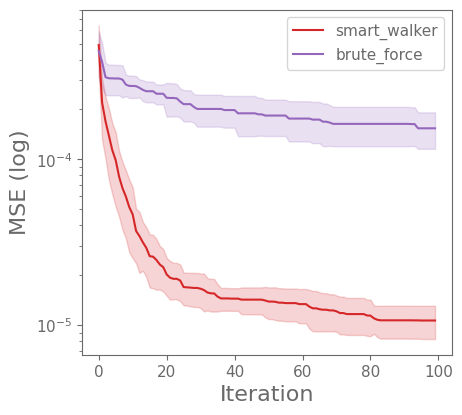

In [31]:
plt.figure(figsize = (4.905, 4.434))
ax = plt.gca()
i = 0
plot_list = []
for key, mean_best, std_best, mean_progress, std_progress in method_evaluation_list:
    color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i+3]
    plt.fill_between(torch.arange(len(mean_progress)), (mean_progress-std_progress).cpu(), (mean_progress+std_progress).cpu(), color=color, alpha=0.2)
    plot, = plt.plot(torch.arange(len(mean_progress)), mean_progress.cpu(), alpha = 1., c = color)
    plot_list.append(plot)
    i = i+1
ax.legend(plot_list, [key for key in method_dict.keys()], prop={'size': 11})
ax.tick_params(axis='both', which='major', labelsize=11)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('MSE (log)', fontsize=16)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig('outputs/bl_optimizer_iterations.pdf')
plt.show()

In [ ]:
t0 = benchmark.Timer(
    stmt='optimize_smart_walker(model, observed_rays, uncompensated_parameters_selected)',
    setup='from __main__ import optimize_smart_walker',
    globals={'model': model, 'observed_rays': observed_rays, 'uncompensated_parameters_selected': uncompensated_parameters_selected},
    num_threads=1,
    label='optimize smart walker',
    sub_label='optimize smart walker')
print(t0.timeit(repetitions))

In [ ]:
plot_observed_rays = observed_rays.squeeze()
plot_min_param_rays = model(loss_min_params)
fig, ax = plt.subplots(1, plot_observed_rays.shape[0], sharex=True, sharey=True, figsize=(32, 9))
with torch.no_grad():
    for i in range(plot_observed_rays.shape[0]):
        ax[i].plot(model(loss_min_params)[i].cpu())
        ax[i].plot(observed_rays.squeeze()[i].cpu())

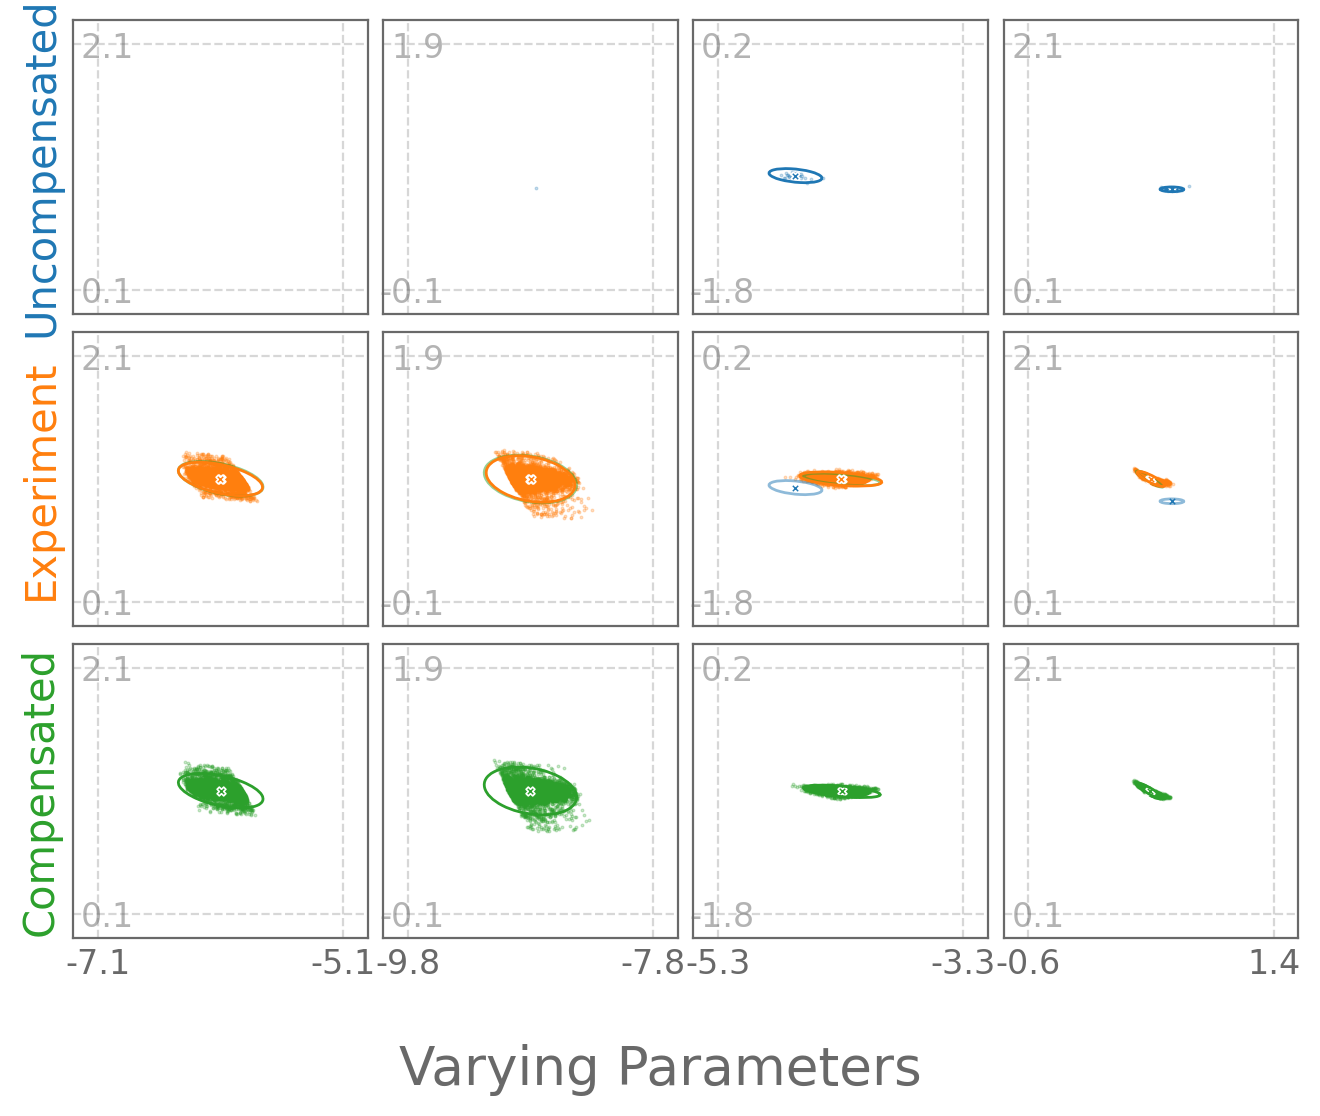

In [25]:
plot_param_tensors(loss_min_params[[0,1,4,6]], uncompensated_parameters_selected[[0,1,4,6]], engine = engine, compensated_parameters=compensated_parameters_selected[[0,1,4,6]])

# Import real data

In [ ]:
def import_real_hist_data(path = 'datasets/metrix_real_data/2021_march_complete', import_set = ['M03', 'M10', 'M18', 'M22', 'M23', 'M24', 'M25', 'M27', 'M28', 'M29', 'M30', 'M32', 'M33', 'M36',
                             'M37', 'M40', 'M41', 'M42', 'M43', 'M44'], check_value_lims=False):
    imported_data = import_data(
                path,
                import_set,
                [0.],
                params(),
                check_value_lims=check_value_lims,
            )
    xy_hist = XYHistogram(50, (-10., 10.), (-3., 3.))
    
    real_data_list = []
    for i in range(len(imported_data)):
        real_data_list.append(xy_hist(imported_data[i]['ray_output']['ImagePlane']))
    
    real_data_point_cloud_list = []
    for i in range(len(imported_data)):
        real_data_point_cloud_list.append(imported_data[i])
    
    real_data_tensor = torch.stack([real_data_list[i][0.0]['histogram'] for i in range(len(real_data_list))])
    real_data_tensor_normalized = surrogate_engine.model.standardizer(real_data_tensor)
    
    uncompensated_parameters_list = []
    for i in range(len(imported_data)):
        uncompensated_entry = torch.tensor([value.get_value() for value in Plot.normalize_parameters(imported_data[i]['param_container_dict'], params()).values()])
        uncompensated_parameters_list.append(uncompensated_entry)
    uncompensated_parameters = torch.stack(uncompensated_parameters_list)
    
    observed_rays = real_data_tensor_normalized.flatten(start_dim=1).unsqueeze(1).float().to(model.device)
    uncompensated_parameters = uncompensated_parameters.unsqueeze(1).float().to(model.device)
    observed_rays_point_cloud = ray_output_to_tensor(real_data_point_cloud_list, 'ImagePlane')
    return observed_rays, uncompensated_parameters, observed_rays_point_cloud
observed_rays_real, uncompensated_parameters_real, observed_rays_point_cloud = import_real_hist_data()

In [35]:
loss_min_params = optimize_smart_walker(model, observed_rays_real, uncompensated_parameters_real)

NameError: name 'observed_rays_real' is not defined

In [ ]:
torch.set_default_device('cpu')
pc = [tensor_to_param_container(loss_min_params[i]) for i in range(loss_min_params.shape[0])]
Plot.plot_engines_comparison(engine, surrogate_engine, pc[:8], MultiLayer([0.]), )

In [34]:
plot_param_tensors(loss_min_params[:], uncompensated_parameters_selected[:], compensated_parameters=compensated_parameters_selected[:])

NameError: name 'loss_min_params' is not defined

In [ ]:
repeated_params = torch.vstack(10*[loss_min_params[1]])
a = repeated_params.clone()
b = repeated_params.clone()
c = repeated_params.clone()
for i, ten in enumerate(a):
    ten[-1]=0.5+0.1*i
    ten[-2]=0.5
for i, ten in enumerate(b):
    ten[-2]=0.5+0.1*i
    ten[-1]=0.5
for i, ten in enumerate(c):
    ten[-1]=0.5
    ten[-2]=0.5#+0.005*i
plot_param_tensors(a[:3], b[:3], compensated_parameters=c[:3])
#print(repeated_params)
#plot_param_tensors(loss_min_params[:], uncompensated_parameters_selected[:], compensated_parameters=compensated_parameters_selected[:])

In [ ]:
loss_min_params.shape, uncompensated_parameters_selected.shape, compensated_parameters_selected.shape

In [ ]:
parameter_comparison_plot = Plot.plot_param_comparison(
    predicted_params=tensor_list_to_param_container_list(loss_min_params.squeeze().unsqueeze(0)),
    epoch=42,
    training_samples_count=len(observed_rays),
    search_space=params(),
    real_params=tensor_list_to_param_container_list(compensated_parameters_selected)[0],
)

In [ ]:
parameter_comparison_plot = Plot.plot_param_comparison(
    predicted_params=tensor_to_param_container(offsets_selected.squeeze()),
    epoch=42,
    training_samples_count=len(observed_rays),
    search_space=RayOptimization.limited_search_space(params(), RandomGenerator(42), max_deviation=max_offset),
    real_params=tensor_list_to_param_container_list(loss_min_params[0] - compensated_parameters_selected.squeeze())[1],
)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import transforms
import numpy as np
from matplotlib.layout_engine import ConstrainedLayoutEngine, TightLayoutEngine
from matplotlib.ticker import NullLocator
from matplotlib.ticker import FormatStrFormatter

rs = np.random.RandomState(11)
x = rs.gamma(4, size=1000)
y = -.5 * x + rs.normal(size=1000)
x = x / 4  -1
y = y/4 +1


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    xlim_min, xlim_max, ylim_min, ylim_max = -2, 2, -2, 2
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    color = plt.rcParams["axes.prop_cycle"].by_key()["color"][1]
    ax.scatter(
    x,
    y,
    s=2.0,
    alpha=0.5,
    linewidths=0.4,
    color=color
    )
    ax.set_xlim(
    Plot.scale_interval(
        xlim_min, xlim_max, 1.2
    )
)
    ax.set_ylim(
        Plot.scale_interval(
            ylim_min, ylim_max, 1.2
        )
    )
    ax.tick_params(axis="both", length=0.0)
    ax.grid(linestyle="dashed", alpha=0.5)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    
    ax.set_xticks((xlim_min, xlim_max))
    ax.set_yticks((ylim_min, ylim_max))
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    #ax_histx.hist(x, bins=bins, color=color)
    x_simulation_hist, _ = torch.histogram(torch.from_numpy(x),bins=50, range=[-2, 2])
    ax_histx.plot(torch.linspace(-2, 2, 50), x_simulation_hist, color=color)
    ax_histx.set_yticklabels([])
    #ax_histy.hist(y, bins=bins, orientation='horizontal', color=color)
    y_simulation_hist, _ = torch.histogram(torch.from_numpy(y),bins=50, range=[-2, 2])
    ax_histy.plot(y_simulation_hist, torch.linspace(-2, 2, 50), color=color)
    ax_histy.set_xticklabels([])


# Create a Figure, which doesn't have to be square.
fig = plt.figure(layout='constrained')
# Create the main Axes, leaving 25% of the figure space at the top and on the
# right to position marginals.
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
# The main Axes' aspect can be fixed.
ax.set(aspect=1)
# Create marginal Axes, which have 25% of the size of the main Axes.  Note that
# the inset Axes are positioned *outside* (on the right and the top) of the
# main Axes, by specifying axes coordinates greater than 1.  Axes coordinates
# less than 0 would likewise specify positions on the left and the bottom of
# the main Axes.
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()


# Evotorch

In [ ]:
from evotorch import Problem
from evotorch.algorithms import SNES
from evotorch.logging import StdOutLogger

def norm(x: torch.Tensor) -> torch.Tensor:
  return torch.linalg.norm(x, dim=-1)

with torch.no_grad():
    observed_rays = model(compensated_parameters_selected)
uncompensated_parameters = uncompensated_parameters_selected
def loss(x: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        tensor_sum = x + uncompensated_parameters
        compensated_rays = model(tensor_sum, clone_output=True)
        compensated_rays = compensated_rays.flatten(start_dim=2)
        loss_orig = ((compensated_rays - observed_rays) ** 2).mean(0).mean(-1)
    return loss_orig

problem = Problem(
  "min",
  loss,
  initial_bounds=(0., 1.),
  solution_length=34,
  vectorized=True,
  device="cuda",  # Enable for GPU support
)

searcher = SNES(problem, popsize=1000, stdev_init=0.3)
_ = StdOutLogger(searcher, interval=1000)

searcher.run(num_generations=10000)

In [ ]:
best_discovered_solution = searcher.status["pop_best"]
print(best_discovered_solution.values)

# SGD

In [ ]:
batch_size = 10000
x = torch.rand((batch_size, 36), requires_grad=True, device=model.device)
optimizer = torch.optim.SGD([x], lr=0.01)  # Adjust the learning rate as needed
torch.autograd.set_detect_anomaly(True)
num_epochs = 1000  # Number of iterations
uncompensated_parameters = uncompensated_parameters_selected
#with torch.no_grad():
observed_rays = model(compensated_parameters_selected)

def function_to_minimize(x):
    tensor_sum = x + uncompensated_parameters
    compensated_rays = model(tensor_sum)
    compensated_rays = compensated_rays.flatten(start_dim=2)
    loss_orig = ((compensated_rays - observed_rays) ** 2).mean(0).mean(-1)
    return loss_orig

pbar = tqdm.trange(num_epochs)
for epoch in pbar:
    optimizer.zero_grad()  # Clear the gradients from the previous step
    
    output = function_to_minimize(x.detach())  # Compute the function's output
    loss = output.mean()  # Compute the mean loss for this batch
    
    loss.backward(retain_graph=True)  # Backpropagate to compute the gradients
    optimizer.step()  # Update the parameters with SGD
    
    # Optionally print the loss to monitor progress
    if epoch % 100 == 0:
        pbar.set_postfix({"loss": loss.item()})